In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import os
import collections
pd.options.display.precision = 2

In [151]:
os.listdir("../data/preprocessed/aktobe120")

['aktobe120_X.csv',
 'aktobe120_Y_effect_na.csv',
 'aktobe120_Y_min_ves.csv',
 'aktobe120_Y_moment.csv',
 'aktobe120_Y_ves_na_kru.csv']

## `Data Preprocessing`

In [152]:
df = pd.read_csv(f"../data/preprocessed/aktobe120/aktobe120_X.csv")
y_ves = pd.read_csv(f"../data/preprocessed/aktobe120/aktobe120_Y_ves_na_kru.csv")
y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1).astype('float64')
print(df.info())
print(y_ves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MD                       339 non-null    float64
 1   Incl.                    339 non-null    float64
 2   Azim.                    339 non-null    float64
 3   Sub-Sea                  339 non-null    float64
 4   TVD                      339 non-null    float64
 5   Local N Coord            339 non-null    float64
 6   Local E Coord            339 non-null    float64
 7   Global N Coord           339 non-null    float64
 8   Global E Coord           339 non-null    float64
 9   Dogleg                   339 non-null    float64
 10  Vertical Section         339 non-null    float64
 11  Body_OD                  339 non-null    float64
 12  Body_ID                  339 non-null    float64
 13  Body_AvgJointLength      339 non-null    float64
 14  Stabilizer_Length        3

In [153]:
y_ves["MD"].head()

0    2359.0
1    2409.0
2    2459.0
3    2509.0
4    2559.0
Name: MD, dtype: float64

In [154]:
y_ves

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2359.0,59.80,71.92,59.40,57.01,52.06,132.07,225.0
1,2409.0,59.19,72.11,59.23,56.10,54.22,131.98,225.0
2,2459.0,58.40,72.72,59.14,55.26,53.84,132.81,225.0
3,2509.0,58.14,72.85,59.13,54.93,53.56,132.74,225.0
4,2559.0,58.86,74.26,60.09,55.76,53.61,132.29,225.0
5,2609.0,58.13,74.98,60.07,55.02,53.26,133.11,225.0
6,2659.0,57.82,75.02,59.99,54.68,53.59,132.98,225.0
7,2709.0,57.21,75.61,59.91,54.02,53.37,132.90,225.0
8,2759.0,57.00,75.57,59.82,53.74,49.69,132.83,225.0
9,2809.0,55.95,76.64,59.72,52.74,49.47,133.27,225.0


In [155]:
df

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
0,100.00,0.30,108.18,117.37,100.00,-0.08,0.25,5.09e+06,9.69e+06,0.09,0.01,101.60,82.30,9.14,0.43,138.91,76.20,26.41,0.25,105
1,110.00,0.41,92.12,127.37,110.00,-0.09,0.31,5.09e+06,9.69e+06,0.45,0.02,101.60,82.30,9.14,0.43,138.91,76.20,26.41,0.25,105
2,120.00,0.36,88.35,137.37,120.00,-0.09,0.38,5.09e+06,9.69e+06,0.17,0.04,101.60,82.30,9.14,0.43,138.91,76.20,26.41,0.25,105
3,130.00,0.27,93.81,147.37,130.00,-0.09,0.43,5.09e+06,9.69e+06,0.28,0.06,101.60,82.30,9.14,0.43,138.91,76.20,26.41,0.25,105
4,140.00,0.26,104.22,157.37,140.00,-0.10,0.48,5.09e+06,9.69e+06,0.15,0.07,101.60,82.30,9.14,0.43,138.91,76.20,26.41,0.25,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.00,90.00,20.11,2243.74,2226.37,763.52,277.73,5.09e+06,9.69e+06,0.00,812.46,88.90,66.09,9.14,0.47,119.86,53.98,25.12,0.30,105
335,2900.00,90.00,20.11,2243.74,2226.37,772.91,281.17,5.09e+06,9.69e+06,0.00,822.46,120.65,40.64,10.44,0.47,119.86,53.98,85.87,0.30,110
336,2910.00,90.00,20.11,2243.74,2226.37,782.30,284.61,5.09e+06,9.69e+06,0.00,832.46,120.65,40.64,9.10,0.47,119.86,53.98,85.87,0.30,105
337,2920.00,90.00,20.11,2243.74,2226.37,791.69,288.05,5.09e+06,9.69e+06,0.00,842.46,120.65,44.45,1.52,0.47,119.86,53.98,43.75,0.30,110


In [156]:
merge = pd.merge_asof(df, y_ves, on="MD")
print(df.shape)
print(merge.shape)
merge

(339, 20)
(339, 27)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,100.00,0.30,108.18,117.37,100.00,-0.08,0.25,5.09e+06,9.69e+06,0.09,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110.00,0.41,92.12,127.37,110.00,-0.09,0.31,5.09e+06,9.69e+06,0.45,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,120.00,0.36,88.35,137.37,120.00,-0.09,0.38,5.09e+06,9.69e+06,0.17,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,130.00,0.27,93.81,147.37,130.00,-0.09,0.43,5.09e+06,9.69e+06,0.28,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140.00,0.26,104.22,157.37,140.00,-0.10,0.48,5.09e+06,9.69e+06,0.15,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.00,90.00,20.11,2243.74,2226.37,763.52,277.73,5.09e+06,9.69e+06,0.00,...,25.12,0.30,105,55.66,76.43,59.57,52.45,50.91,133.19,225.0
335,2900.00,90.00,20.11,2243.74,2226.37,772.91,281.17,5.09e+06,9.69e+06,0.00,...,85.87,0.30,110,55.66,76.43,59.57,52.45,50.91,133.19,225.0
336,2910.00,90.00,20.11,2243.74,2226.37,782.30,284.61,5.09e+06,9.69e+06,0.00,...,85.87,0.30,105,54.95,76.60,59.36,51.71,51.11,132.62,225.0
337,2920.00,90.00,20.11,2243.74,2226.37,791.69,288.05,5.09e+06,9.69e+06,0.00,...,43.75,0.30,110,54.95,76.60,59.36,51.71,51.11,132.62,225.0


<Axes: >

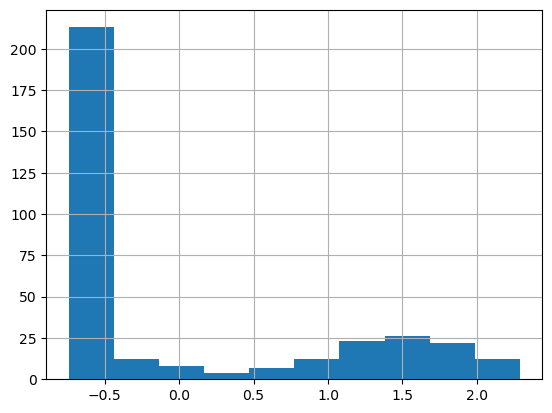

In [157]:
((df["Dogleg"]-df["Dogleg"].mean()) / df["Dogleg"].std()).hist()

In [158]:
df_dict = collections.defaultdict(list)
df_dict_val = collections.defaultdict(list)
df_target_cols = {}
df_target_cols_val = {}
train_folders = ['moldabek2737', "aktobe120"]
val_folders = ["balgimbayev245"]
types = [
    "ves_na_kru", 
    "effect_na", 
    "moment", 
    "min_ves"
]

print("--- TRAIN ---")
for folder in train_folders:
    print(folder)
    for type_name in types:
        print("\t", type_name)
        df = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_X.csv")
        y_ves = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_Y_{type_name}.csv")
        
        if type_name == "effect_na":
            y_ves = y_ves.rename({"Глубина по стволу" : "MD"}, axis=1).astype('float64')
        else:
            y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1).astype('float64')
        
        target_cols = list(set(y_ves.columns) - set(["MD"]))

        merge_ves = pd.merge_asof(df, y_ves, on="MD")
        df_dict[type_name].append(merge_ves)
        df_target_cols[type_name] = target_cols

print("\n\n--- VALIDATION ---")

for folder in val_folders:
    print(folder)
    for type_name in types:
        print("\t", type_name)
        df = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_X.csv")
        y_ves = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_Y_{type_name}.csv")
        
        if type_name == "effect_na":
            y_ves = y_ves.rename({"Глубина по стволу" : "MD"}, axis=1).astype('float64')
        else:
            y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1).astype('float64')
        
        target_cols = list(set(y_ves.columns) - set(["MD"]))
        merge_ves = pd.merge_asof(df, y_ves, on="MD")
        df_dict_val[type_name].append(merge_ves)
        df_target_cols_val[type_name] = target_cols        

--- TRAIN ---
moldabek2737
	 ves_na_kru
	 effect_na
	 moment
	 min_ves
aktobe120
	 ves_na_kru
	 effect_na
	 moment
	 min_ves


--- VALIDATION ---
balgimbayev245
	 ves_na_kru
	 effect_na
	 moment
	 min_ves


In [159]:
pd.concat(df_dict["min_ves"])[df_target_cols["min_ves"]]

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором)
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
334,4.11,12.32,3.17,11.56
335,4.11,12.32,3.17,11.56
336,2.89,10.94,2.06,10.66
337,2.89,10.94,2.06,10.66


In [160]:
concanted_df = {}
for type_name in types:
    temp = pd.concat(df_dict[type_name])
    temp = temp.sort_values("MD")
    # temp["is_train"] = temp[df_target_cols[type_name]].notnull().all(axis=1).astype(float)
    temp[df_target_cols[type_name]] = temp[df_target_cols[type_name]].fillna(0)
    # df_target_cols[type_name].append("is_train")
    concanted_df[type_name] = temp

In [161]:
concanted_df = {}
for type_name in types:
    # Concatenate DataFrames
    temp = pd.concat(df_dict[type_name])
    
    # Sort the concatenated DataFrame by "MD"
    temp = temp.sort_values("MD")
    
    # Drop rows with missing values in the target columns
    temp = temp.dropna(subset=df_target_cols[type_name])
    
    # Store the cleaned DataFrame
    concanted_df[type_name] = temp


In [162]:
concanted_df

{'ves_na_kru':           MD  Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
 29    300.00  44.74   0.35   206.37   282.88          71.20           0.43   
 30    304.74  46.00   0.35   209.69   286.21          74.57           0.46   
 31    310.00  46.26   0.35   213.34   289.86          78.36           0.48   
 32    320.00  46.76   0.35   220.22   296.74          85.62           0.52   
 33    324.74  47.00   0.35   223.46   299.98          89.08           0.54   
 ..       ...    ...    ...      ...      ...            ...            ...   
 334  2890.00  90.00  20.11  2243.74  2226.37         763.52         277.73   
 335  2900.00  90.00  20.11  2243.74  2226.37         772.91         281.17   
 336  2910.00  90.00  20.11  2243.74  2226.37         782.30         284.61   
 337  2920.00  90.00  20.11  2243.74  2226.37         791.69         288.05   
 338  2927.23  90.00  20.11  2243.74  2226.37         798.48         290.53   
 
      Global N Coord  Global E Coord

In [163]:
concanted_df["effect_na"]["Грузоподъёмность вышки"].isna().sum()

0

In [164]:
df_dict["effect_na"][1]["Грузоподъёмность вышки"].isna().sum()

0

In [165]:
df_dict

defaultdict(list,
            {'ves_na_kru': [        MD  Incl.  Azim.  Sub-Sea     TVD  Local N Coord  Local E Coord  \
              0     0.00   0.00   0.00   -76.52    0.00           0.00       0.00e+00   
              1    40.00   0.00   0.00   -36.52   40.00           0.00       0.00e+00   
              2    50.00   0.83   0.35   -26.52   50.00           0.07       0.00e+00   
              3    60.00   1.67   0.35   -16.52   60.00           0.29       2.00e-03   
              4    70.00   2.50   0.35    -6.53   69.99           0.65       4.00e-03   
              ..     ...    ...    ...      ...     ...            ...            ...   
              75  730.00  90.00   0.85   276.48  353.00         480.78       5.86e+00   
              76  740.00  90.00   0.85   276.48  353.00         490.78       6.01e+00   
              77  750.00  90.00   0.85   276.48  353.00         500.78       6.16e+00   
              78  760.00  90.00   0.85   276.48  353.00         510.78       6

In [166]:
concanted_df

{'ves_na_kru':           MD  Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
 29    300.00  44.74   0.35   206.37   282.88          71.20           0.43   
 30    304.74  46.00   0.35   209.69   286.21          74.57           0.46   
 31    310.00  46.26   0.35   213.34   289.86          78.36           0.48   
 32    320.00  46.76   0.35   220.22   296.74          85.62           0.52   
 33    324.74  47.00   0.35   223.46   299.98          89.08           0.54   
 ..       ...    ...    ...      ...      ...            ...            ...   
 334  2890.00  90.00  20.11  2243.74  2226.37         763.52         277.73   
 335  2900.00  90.00  20.11  2243.74  2226.37         772.91         281.17   
 336  2910.00  90.00  20.11  2243.74  2226.37         782.30         284.61   
 337  2920.00  90.00  20.11  2243.74  2226.37         791.69         288.05   
 338  2927.23  90.00  20.11  2243.74  2226.37         798.48         290.53   
 
      Global N Coord  Global E Coord

<Axes: >

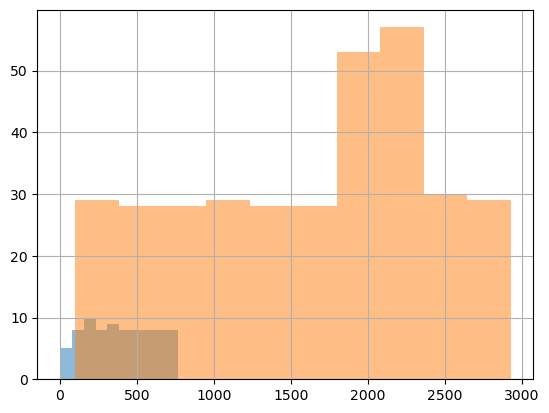

In [167]:
df_dict[type_name][0]["MD"].hist(alpha=.5)
df_dict[type_name][1]["MD"].hist(alpha=.5)
# df_dict_val[type_name][0]["MD"].hist(alpha=.5)

In [168]:
types

['ves_na_kru', 'effect_na', 'moment', 'min_ves']

In [169]:
df_target_cols

{'ves_na_kru': ['Мин. вес до спирального изгиба (спуск)',
  'Макс. вес до предела текучести (подъём)',
  'Грузоподъёмность вышки',
  'Подъём',
  'Бурение ротором',
  'Спуск',
  'Бурение ГЗД'],
 'effect_na': ['Синусоидальный изгиб(все операции)',
  'Спиральный изгиб(без вращения)',
  'Спиральный изгиб(с вращением)',
  'Грузоподъёмность вышки',
  'Предел натяжения',
  'Глубина по вертикали',
  'Бурение ротором',
  'Бурение ГЗД',
  'Спуск',
  'Подъём'],
 'moment': ['Момент свинчивания',
  ' Make-up Torque',
  'Бурение ротором',
  'Спуск',
  'Подъём'],
 'min_ves': ['Мин. вес на долоте до спирального изгиба (бурение ГЗД)',
  'Мин. вес на долоте до спирального изгиба (бурение ротором)',
  'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)',
  'Мин. вес на долоте до синусоидального изгиба (бурение ротором)']}

In [109]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the current type for processing
current_type = "min_ves"

# Extract the relevant data from the dataframe
X = concanted_df[current_type]
x_target_cols = df_target_cols[current_type]

# Separate the target columns
y = X[x_target_cols]
X = X.drop(x_target_cols, axis=1)

# Assign training data
X_train, y_train = X, y

# Assign test data
X_test = df_dict_val[current_type][0].drop(df_target_cols_val[current_type], axis=1)
y_test = df_dict_val[current_type][0][df_target_cols_val[current_type]]

# Feature engineering function
def add_features(df):
    df["sin_Incl."] = np.sin(df["Incl."])
    df["cos_Incl."] = np.cos(df["Incl."])
    df["tan_Incl."] = np.tan(df["Incl."])
    
    df["sin_Azim."] = np.sin(df["Azim."])
    df["cos_Azim."] = np.cos(df["Azim."])
    df["tan_Azim."] = np.tan(df["Azim."])
    
    df["Local_polar_angle"] = np.arctan2(df["Local N Coord"], df["Local E Coord"])
    df["Local_polar_r"] = np.sqrt(df["Local N Coord"]**2 + df["Local E Coord"]**2)
    
    df["Global_polar_angle"] = np.arctan2(df["Global N Coord"], df["Global E Coord"])
    df["Global_polar_r"] = np.sqrt(df["Global N Coord"]**2 + df["Global E Coord"]**2)
    return df

# Apply feature engineering to both training and test data
X_train = add_features(X_train)
X_test = add_features(X_test)

print(set(X_train.columns)- set(X_test.columns))
# Initialize scalers for feature scaling
x_scaler, y_scaler = StandardScaler(), StandardScaler()


# Scale the training data
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

# Scale the test data
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# Output the shape of the scaled training data and the test data
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test_scaled.shape, y_test_scaled.shape)


set()
(111, 30) (111, 4)
(43, 30) (43, 4)


In [110]:
X_train

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,sin_Incl.,cos_Incl.,tan_Incl.,sin_Azim.,cos_Azim.,tan_Azim.,Local_polar_angle,Local_polar_r,Global_polar_angle,Global_polar_r
29,300.00,44.74,0.35,206.37,282.88,71.20,0.43,5.29e+06,1.03e+07,8.0,...,0.69,0.73,0.94,0.34,0.94,0.37,1.56,71.20,0.48,1.16e+07
30,304.74,46.00,0.35,209.69,286.21,74.57,0.46,5.29e+06,1.03e+07,8.0,...,0.90,-0.43,-2.09,0.34,0.94,0.37,1.56,74.57,0.48,1.16e+07
31,310.00,46.26,0.35,213.34,289.86,78.36,0.48,5.29e+06,1.03e+07,1.5,...,0.76,-0.65,-1.16,0.34,0.94,0.37,1.56,78.36,0.48,1.16e+07
32,320.00,46.76,0.35,220.22,296.74,85.62,0.52,5.29e+06,1.03e+07,1.5,...,0.35,-0.94,-0.38,0.34,0.94,0.37,1.56,85.62,0.48,1.16e+07
33,324.74,47.00,0.35,223.46,299.98,89.08,0.54,5.29e+06,1.03e+07,1.5,...,0.12,-0.99,-0.12,0.34,0.94,0.37,1.56,89.08,0.48,1.16e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.00,90.00,20.11,2243.74,2226.37,763.52,277.73,5.09e+06,9.69e+06,0.0,...,0.89,-0.45,-2.00,0.95,0.31,3.12,1.22,812.47,0.48,1.09e+07
335,2900.00,90.00,20.11,2243.74,2226.37,772.91,281.17,5.09e+06,9.69e+06,0.0,...,0.89,-0.45,-2.00,0.95,0.31,3.12,1.22,822.46,0.48,1.09e+07
336,2910.00,90.00,20.11,2243.74,2226.37,782.30,284.61,5.09e+06,9.69e+06,0.0,...,0.89,-0.45,-2.00,0.95,0.31,3.12,1.22,832.46,0.48,1.09e+07
337,2920.00,90.00,20.11,2243.74,2226.37,791.69,288.05,5.09e+06,9.69e+06,0.0,...,0.89,-0.45,-2.00,0.95,0.31,3.12,1.22,842.47,0.48,1.09e+07


In [111]:
X_test.shape

(43, 30)

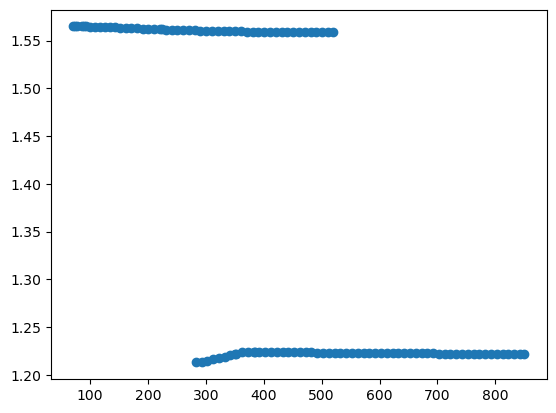

In [112]:
plt.scatter(X["Local_polar_r"], X["Local_polar_angle"])

In [113]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [114]:
X_test_scaled

array([[-1.56609881, -7.06236945, -1.15940216, ..., -2.06013293,
         5.32707131, -1.26980626],
       [-1.25614104, -7.06236945, -1.15940216, ..., -2.06013293,
         5.32707131, -1.26980626],
       [-1.22796306, -6.64255219, 25.02045637, ..., -2.05382994,
         5.32707472, -1.2698105 ],
       ...,
       [-0.41080166,  0.43436723, 25.02045637, ...,  1.30695007,
         5.32889279, -1.27207302],
       [-0.38262369,  0.43436723, 25.02045637, ...,  1.45030554,
         5.32897034, -1.27216953],
       [-0.36284368,  0.43436723, 25.02045637, ...,  1.55094038,
         5.32902479, -1.27223728]])

In [115]:
y_train.isna().sum()

Мин. вес на долоте до спирального изгиба (бурение ГЗД)            0
Мин. вес на долоте до спирального изгиба (бурение ротором)        0
Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)        0
Мин. вес на долоте до синусоидального изгиба (бурение ротором)    0
dtype: int64

In [116]:
y_train

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором)
29,6.93,7.34,5.07,6.82
30,6.93,7.34,5.07,6.82
31,11.06,10.36,6.93,9.20
32,7.40,7.76,5.27,7.16
33,7.40,7.76,5.27,7.16
...,...,...,...,...
334,4.11,12.32,3.17,11.56
335,4.11,12.32,3.17,11.56
336,2.89,10.94,2.06,10.66
337,2.89,10.94,2.06,10.66


In [117]:
X_train.isna().sum()

MD                         0
Incl.                      0
Azim.                      0
Sub-Sea                    0
TVD                        0
Local N Coord              0
Local E Coord              0
Global N Coord             0
Global E Coord             0
Dogleg                     0
Vertical Section           0
Body_OD                    0
Body_ID                    0
Body_AvgJointLength        0
Stabilizer_Length          0
Stabilizer_OD              0
Stabilizer_ID              0
Weight                     0
Coefficient of Friction    0
Minimum Yield Stress       0
sin_Incl.                  0
cos_Incl.                  0
tan_Incl.                  0
sin_Azim.                  0
cos_Azim.                  0
tan_Azim.                  0
Local_polar_angle          0
Local_polar_r              0
Global_polar_angle         0
Global_polar_r             0
dtype: int64

## `Multilayer Perceptron`

In [118]:
model = tf.keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu", kernel_regularizer='l2', bias_regularizer='l2'),
    layers.Dense(48, activation="relu", kernel_regularizer='l2', bias_regularizer='l2'),
    layers.Dense(len(x_target_cols))
])
# model.summary()

In [119]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.Huber())

In [120]:
%%time
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=4,
    batch_size=32,
    # Suppress logging.
    verbose=2,
    shuffle=False,
#     callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
    # Calculate validation results on 20% of the training data.
    validation_split = 0.33)


Epoch 1/4
3/3 - 1s - loss: 1.5341 - val_loss: 1.2288 - 1s/epoch - 487ms/step
Epoch 2/4
3/3 - 0s - loss: 1.1256 - val_loss: 1.0954 - 48ms/epoch - 16ms/step
Epoch 3/4
3/3 - 0s - loss: 0.9354 - val_loss: 0.9392 - 81ms/epoch - 27ms/step
Epoch 4/4
3/3 - 0s - loss: 0.7872 - val_loss: 0.8278 - 40ms/epoch - 13ms/step
CPU times: total: 1.73 s
Wall time: 1.74 s


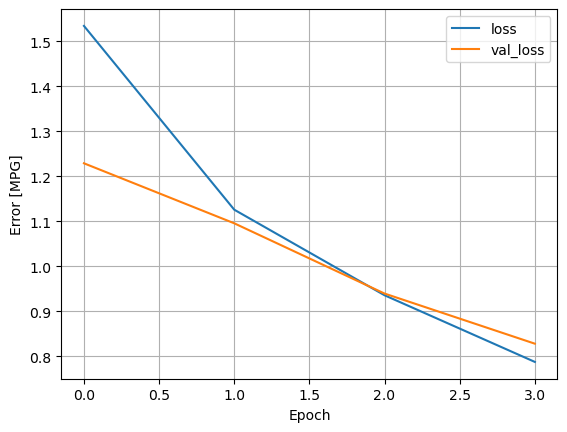

In [121]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [122]:
ff = pd.DataFrame(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))), columns=y_test.columns)
# ff[y_test.reset_index()["is_train"]==1.0]["is_train"].hist(density=True)
# ff[y_test.reset_index()["is_train"]==0.0]["is_train"].hist(density=True)

2/2 [==============================] - 0s 8ms/step


In [123]:
diff = ff - y_test.reset_index(drop=True)
abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum() == 0, 1, y_test.reset_index(drop=True).sum())

Мин. вес на долоте до спирального изгиба (бурение ГЗД)            2.66
Мин. вес на долоте до спирального изгиба (бурение ротором)        1.83
Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)        0.89
Мин. вес на долоте до синусоидального изгиба (бурение ротором)    1.43
dtype: float64

## `XBGoost Regressor`

In [124]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=100, 
                       colsample_bynode=0.8,
                       max_depth=6,
                       tree_method="hist",
                       subsample=0.9,
                       min_child_weight=2,
                       multi_strategy="multi_output_tree")
reg = MultiOutputRegressor(LGBMRegressor(verbose=-1, subsample=0.7, subsample_freq=2))
reg.fit(X, y)

MultiOutputRegressor(estimator=LGBMRegressor(subsample=0.7, subsample_freq=2,
                                             verbose=-1))

In [125]:
predictions = pd.DataFrame(reg.predict(X_test), columns=y.columns)

In [126]:
diff = predictions - y_test.reset_index(drop=True)
abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum() == 0, 1, y_test.reset_index(drop=True).sum())

Мин. вес на долоте до спирального изгиба (бурение ГЗД)            0.52
Мин. вес на долоте до спирального изгиба (бурение ротором)        0.13
Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)        0.27
Мин. вес на долоте до синусоидального изгиба (бурение ротором)    0.14
dtype: float64

In [127]:
predictions

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором)
0,9.34,10.03,6.06,9.66
1,9.34,10.03,6.06,9.66
2,9.09,10.04,5.62,9.05
3,9.09,10.04,5.62,9.05
4,9.09,10.04,5.62,9.05
5,9.02,9.92,5.62,9.05
6,9.09,10.04,5.62,9.05
7,9.09,10.04,5.62,9.05
8,9.41,10.61,5.64,9.77
9,9.50,10.91,5.73,9.91


## `Multilayer Perceptron + XGBoost Regressor`

In [170]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from xgboost import XGBRegressor

class MultiOutputStackingRegressor(BaseEstimator):
    def __init__(self, nn_epochs=4, nn_batch_size=32):
        self.nn_epochs = nn_epochs
        self.nn_batch_size = nn_batch_size
        self.nn_model = None
        self.xgb_model = None
    
    def fit(self, X, y):
        # Step 1: Split data into folds for cross-validation
        kf = KFold(n_splits=3, shuffle=False)
        xgb_inputs = []
        xgb_targets = []
        
        # Step 2: Train Keras neural network and collect predictions
        nn_preds = np.empty_like(y)
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Train Keras neural network
            nn_model = self._train_keras_nn(X_train, y_train)
            
            # Predict using Keras neural network
            nn_pred = nn_model.predict(X_val)
            nn_preds[val_index] = nn_pred
            
            # Collect inputs and targets for XGBoost training
            xgb_inputs.append(np.concatenate((X_val, nn_pred), axis=1))
            xgb_targets.append(y_val)
        
        # Step 3: Train XGBoost regressor on combined dataset
        combined_xgb_input = np.concatenate(xgb_inputs)
        combined_xgb_target = np.concatenate(xgb_targets)
        self.xgb_model = self._train_xgboost(combined_xgb_input, combined_xgb_target)
        
        # Step 4: Train neural network on entire dataset
        self.nn_model = self._train_keras_nn(X, y)
    
    def predict(self, X):
        # Step 1: Predict using neural network
        nn_preds = self.nn_model.predict(X)
        
        # Step 2: Combine predictions with original input dataset
        xgb_input = np.concatenate((X, nn_preds), axis=1)

        # Step 3: Predict using XGBoost regressor
        return self.xgb_model.predict(xgb_input)
    
    def _train_keras_nn(self, X, y):
        input_shape = X.shape[1]
        output_shape = y.shape[1]
        
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(64, input_shape=(input_shape,), activation="relu", kernel_regularizer='l1', bias_regularizer='l1'))
        model.add(Dense(48, activation='relu', kernel_regularizer='l1', bias_regularizer='l1'))
        model.add(Dense(output_shape, activation=None))  # No activation for regression
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=keras.losses.Huber()
        )
        
        model.fit(X, y, epochs=self.nn_epochs, batch_size=self.nn_batch_size, verbose=0, shuffle=False)
        return model
    
    def _train_xgboost(self, X, y):
        xgb = XGBRegressor(n_estimators=100, 
                       colsample_bytree=0.5,
                       max_depth=5,
                       tree_method="hist",
                       subsample=1.0,
                       reg_lambda=1e-03,
                       min_child_weight=3,
                       multi_strategy="multi_output_tree")
        # xgb = MultiOutputRegressor(LGBMRegressor(verbose=-1, subsample=0.7, subsample_freq=2))
        xgb.fit(X, y)
        return xgb


In [129]:
model = MultiOutputStackingRegressor()
model.fit(X_train_scaled, y_train_scaled)

2/2 [==============================] - 0s 3ms/step


In [130]:
X_test.shape

(43, 30)

In [131]:
predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))), columns=y.columns)
diff = predictions - y_test.reset_index(drop=True)
abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum() == 0, 1, y_test.reset_index(drop=True).sum())

2/2 [==============================] - 0s 3ms/step


Мин. вес на долоте до спирального изгиба (бурение ГЗД)            0.26
Мин. вес на долоте до спирального изгиба (бурение ротором)        0.16
Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)        0.28
Мин. вес на долоте до синусоидального изгиба (бурение ротором)    0.17
dtype: float64

In [132]:
predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))), columns=y.columns)
diff = predictions - y_test.reset_index(drop=True)
abs(diff).sum() / (y_test.reset_index(drop=True).sum().abs())

2/2 [==============================] - 0s 2ms/step


Мин. вес на долоте до спирального изгиба (бурение ГЗД)            0.26
Мин. вес на долоте до спирального изгиба (бурение ротором)        0.16
Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)        0.28
Мин. вес на долоте до синусоидального изгиба (бурение ротором)    0.17
dtype: float64

In [133]:
df_dict_val

defaultdict(list,
            {'ves_na_kru': [         MD  Incl.  Azim.  Sub-Sea     TVD  Local N Coord  Local E Coord  \
              0      0.00   0.00    0.0    21.76    0.00           0.00           0.00   
              1    330.00   0.00    0.0   351.76  330.00           0.00           0.00   
              2    360.00   5.04  248.0   381.72  359.96          -0.49          -1.22   
              3    390.00  10.08  248.0   411.45  389.69          -1.97          -4.88   
              4    420.00  15.12  248.0   440.72  418.96          -4.42         -10.95   
              5    450.00  20.16  248.0   469.30  447.54          -7.83         -19.37   
              6    480.00  25.20  248.0   496.97  475.21         -12.16         -30.09   
              7    510.00  30.24  248.0   523.52  501.76         -17.39         -43.03   
              8    540.00  35.28  248.0   548.74  526.98         -23.46         -58.08   
              9    570.00  40.32  248.0   572.44  550.68         -30

In [134]:
types

['ves_na_kru', 'effect_na', 'moment', 'min_ves']

In [135]:
concanted_df

{'ves_na_kru':           MD  Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
 29    300.00  44.74   0.35   206.37   282.88          71.20           0.43   
 30    304.74  46.00   0.35   209.69   286.21          74.57           0.46   
 31    310.00  46.26   0.35   213.34   289.86          78.36           0.48   
 32    320.00  46.76   0.35   220.22   296.74          85.62           0.52   
 33    324.74  47.00   0.35   223.46   299.98          89.08           0.54   
 ..       ...    ...    ...      ...      ...            ...            ...   
 334  2890.00  90.00  20.11  2243.74  2226.37         763.52         277.73   
 335  2900.00  90.00  20.11  2243.74  2226.37         772.91         281.17   
 336  2910.00  90.00  20.11  2243.74  2226.37         782.30         284.61   
 337  2920.00  90.00  20.11  2243.74  2226.37         791.69         288.05   
 338  2927.23  90.00  20.11  2243.74  2226.37         798.48         290.53   
 
      Global N Coord  Global E Coord

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the function to process a given type and return the WMAPE dataframe
def calculate_wmape(current_type):
    # Extract the relevant data from the dataframe
    X = concanted_df[current_type]
    x_target_cols = df_target_cols[current_type]

    # Separate the target columns
    y = X[x_target_cols]
    X = X.drop(x_target_cols, axis=1)

    # Assign training data
    X_train, y_train = X, y

    # Assign test data
    X_test = df_dict_val[current_type][0].drop(df_target_cols_val[current_type], axis=1)
    y_test = df_dict_val[current_type][0][df_target_cols_val[current_type]]

    # Feature engineering function
    def add_features(df):
        df["sin_Incl."] = np.sin(df["Incl."])
        df["cos_Incl."] = np.cos(df["Incl."])
        df["tan_Incl."] = np.tan(df["Incl."])
        
        df["sin_Azim."] = np.sin(df["Azim."])
        df["cos_Azim."] = np.cos(df["Azim."])
        df["tan_Azim."] = np.tan(df["Azim."])
        
        df["Local_polar_angle"] = np.arctan2(df["Local N Coord"], df["Local E Coord"])
        df["Local_polar_r"] = np.sqrt(df["Local N Coord"]**2 + df["Local E Coord"]**2)
        
        df["Global_polar_angle"] = np.arctan2(df["Global N Coord"], df["Global E Coord"])
        df["Global_polar_r"] = np.sqrt(df["Global N Coord"]**2 + df["Global E Coord"]**2)
        return df

    # Apply feature engineering to both training and test data
    X_train = add_features(X_train)
    X_test = add_features(X_test)

    # Initialize scalers for feature scaling
    x_scaler, y_scaler = StandardScaler(), StandardScaler()

    # Scale the training data
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)

    # Scale the test data
    X_test_scaled = x_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)

    # Define and train the model
    model = MultiOutputStackingRegressor()
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions and calculate WMAPE
    predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y.columns)
    diff = predictions - y_test.reset_index(drop=True)
    wmape = abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum().abs() == 0, 1, y_test.reset_index(drop=True).sum().abs())
    
    # Add the current type to the WMAPE dataframe
    wmape_df = wmape.reset_index().rename(columns={0: 'wmape'})
    wmape_df['type'] = current_type

    return wmape_df


# Initialize an empty list to store WMAPE dataframes
wmape_dfs = []

# Traverse through types and calculate WMAPE for each type
for current_type in types:
    wmape_df = calculate_wmape(current_type)
    wmape_dfs.append(wmape_df)

# Concatenate all WMAPE dataframes
concatenated_wmape_df = pd.concat(wmape_dfs, ignore_index=True)

# Export the concatenated dataframe to a CSV file
concatenated_wmape_df.to_csv('wmape_summary.csv', index=False)

print("WMAPE summary has been exported to 'wmape_summary.csv'.")


2/2 [==============================] - 0s 3ms/step
WMAPE summary has been exported to 'wmape_summary.csv'.


In [171]:
df_dict_val_new = {}
for type_name in types:
    # Concatenate DataFrames
    temp = pd.concat(df_dict_val[type_name])
    
    # Drop rows with missing values in the target columns
    temp = temp.dropna(subset=df_target_cols[type_name])
    
    # Store the cleaned DataFrame
    df_dict_val_new[type_name] = temp


In [172]:
# Combine concanted_df and df_dict_val_new into one dataframe
df_combined = {}
for type_name in types:
    df_combined[type_name] = pd.concat([concanted_df[type_name], df_dict_val_new[type_name]], ignore_index=True)

In [173]:
df_combined

{'ves_na_kru':           MD  Incl.   Azim.  Sub-Sea     TVD  Local N Coord  Local E Coord  \
 0     300.00  44.74    0.35   206.37  282.88          71.20           0.43   
 1     304.74  46.00    0.35   209.69  286.21          74.57           0.46   
 2     310.00  46.26    0.35   213.34  289.86          78.36           0.48   
 3     320.00  46.76    0.35   220.22  296.74          85.62           0.52   
 4     324.74  47.00    0.35   223.46  299.98          89.08           0.54   
 ..       ...    ...     ...      ...     ...            ...            ...   
 126  1170.00  90.00  248.00   681.28  659.52        -241.48        -597.68   
 127  1200.00  90.00  248.00   681.28  659.52        -252.72        -625.49   
 128  1230.00  90.00  248.00   681.28  659.52        -263.95        -653.31   
 129  1260.00  90.00  248.00   681.28  659.52        -275.19        -681.12   
 130  1281.06  90.00  248.00   681.28  659.52        -283.08        -700.65   
 
      Global N Coord  Global E Coord

In [174]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the function to process a given type and return the WMAPE dataframe
def calculate_wmape(current_type):
    # Extract the relevant data from the dataframe
    X = df_combined[current_type]
    x_target_cols = df_target_cols[current_type]

    # Separate the target columns
    y = X[x_target_cols]
    X = X.drop(x_target_cols, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Feature engineering function
    def add_features(df):
        df["sin_Incl."] = np.sin(df["Incl."])
        df["cos_Incl."] = np.cos(df["Incl."])
        df["tan_Incl."] = np.tan(df["Incl."])
        
        df["sin_Azim."] = np.sin(df["Azim."])
        df["cos_Azim."] = np.cos(df["Azim."])
        df["tan_Azim."] = np.tan(df["Azim."])
        
        df["Local_polar_angle"] = np.arctan2(df["Local N Coord"], df["Local E Coord"])
        df["Local_polar_r"] = np.sqrt(df["Local N Coord"]**2 + df["Local E Coord"]**2)
        
        df["Global_polar_angle"] = np.arctan2(df["Global N Coord"], df["Global E Coord"])
        df["Global_polar_r"] = np.sqrt(df["Global N Coord"]**2 + df["Global E Coord"]**2)
        return df

    # Apply feature engineering to both training and test data
    X_train = add_features(X_train)
    X_test = add_features(X_test)

    # Initialize scalers for feature scaling
    x_scaler, y_scaler = StandardScaler(), StandardScaler()

    # Scale the training data
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)

    # Scale the test data
    X_test_scaled = x_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)

    # Define and train the model
    model = MultiOutputStackingRegressor()
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions and calculate WMAPE
    predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y.columns)
    diff = predictions - y_test.reset_index(drop=True)
    wmape = abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum().abs() == 0, 1, y_test.reset_index(drop=True).sum().abs())
    
    # Add the current type to the WMAPE dataframe
    wmape_df = wmape.reset_index().rename(columns={0: 'wmape'})
    wmape_df['type'] = current_type

    return wmape_df


# Initialize an empty list to store WMAPE dataframes
wmape_dfs = []

# Traverse through types and calculate WMAPE for each type
for current_type in types:
    wmape_df = calculate_wmape(current_type)
    wmape_dfs.append(wmape_df)

# Concatenate all WMAPE dataframes
concatenated_wmape_df = pd.concat(wmape_dfs, ignore_index=True)

# Export the concatenated dataframe to a CSV file
concatenated_wmape_df.to_csv('wmape_summary.csv', index=False)

print("WMAPE summary has been exported to 'wmape_summary.csv'.")


1/1 [==============================] - 0s 72ms/step
WMAPE summary has been exported to 'wmape_summary.csv'.


In [175]:
concatenated_wmape_df

,index,wmape,type
0,Мин. вес до спирального изгиба (спуск),1.12e-02,ves_na_kru
1,Макс. вес до предела текучести (подъём),8.39e-03,ves_na_kru
2,Грузоподъёмность вышки,0.00e+00,ves_na_kru
3,Подъём,3.85e-03,ves_na_kru
4,Бурение ротором,2.83e-03,ves_na_kru
5,Спуск,5.14e-03,ves_na_kru
6,Бурение ГЗД,6.11e-03,ves_na_kru
7,Синусоидальный изгиб(все операции),2.56e-01,effect_na
8,Спиральный изгиб(без вращения),2.56e-01,effect_na
9,Спиральный изгиб(с вращением),2.56e-01,effect_na


In [176]:
concatenated_wmape_df['wmape%'] = concatenated_wmape_df['wmape'].apply(lambda x: '{:.2f}%'.format(x * 100))

In [177]:
concatenated_wmape_df

,index,wmape,type,wmape%
0,Мин. вес до спирального изгиба (спуск),1.12e-02,ves_na_kru,1.12%
1,Макс. вес до предела текучести (подъём),8.39e-03,ves_na_kru,0.84%
2,Грузоподъёмность вышки,0.00e+00,ves_na_kru,0.00%
3,Подъём,3.85e-03,ves_na_kru,0.38%
4,Бурение ротором,2.83e-03,ves_na_kru,0.28%
5,Спуск,5.14e-03,ves_na_kru,0.51%
6,Бурение ГЗД,6.11e-03,ves_na_kru,0.61%
7,Синусоидальный изгиб(все операции),2.56e-01,effect_na,25.61%
8,Спиральный изгиб(без вращения),2.56e-01,effect_na,25.61%
9,Спиральный изгиб(с вращением),2.56e-01,effect_na,25.61%
